In [55]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
from patsy import dmatrices
from stargazer.stargazer import Stargazer

import matplotlib.pyplot as plt
import seaborn as sns

from mav_analysis.config import dir_config
from analysis_utils.graphing_utils import (
    InteractionCIPlotter,
    ScatterLowessCIPlotter,
    ViolinPlotter,
)


# Analyzing train delays of the Hungarian Railway system
## A graph-based approach

**authors: Seneca Miller, István Járay**

**course: Data Analysis 2, Coding 1**

**submission date: 2025/01/05**

**program: Central European University**

# Analysis

In [56]:
df = (
    pd.read_parquet(dir_config.analysis_data_dir / "daily_vertex_attributes.parquet")
    .reset_index()
    .rename(
        columns={
            "incoming": "num_incoming_trains",
            "outgoing": "num_outgoing_trains",
            "sum_incoming_outgoing": "num_total_trains",
            "vertex ID": "vertex_id",
        }
    )
)

In [57]:
# Removing the first and last days
# Since this is a scraped dataset, the first and last days are not complete
df = df[df["date"] != df["date"].min()]
df = df[df["date"] != df["date"].max()]

In [58]:
# convert datetime day of week to english name
df["day_of_week_name"] = (
    df["day_of_week"]
    .map(
        {
            0: "Monday",
            1: "Tuesday",
            2: "Wednesday",
            3: "Thursday",
            4: "Friday",
            5: "Saturday",
            6: "Sunday",
        }
    )
    .astype("category")
    .cat.as_ordered()
)

df["is_weekend"] = (
    df["day_of_week_name"]
    .isin(["Saturday", "Sunday"])
    .map({True: "Weekend", False: "Weekday"})
    .astype("category")
    .cat.as_ordered()
)

## Describing the data

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27715 entries, 1205 to 28919
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   vertex_id                   27715 non-null  int64         
 1   stop_id                     27715 non-null  int64         
 2   stop_name                   27715 non-null  object        
 3   stop_lat                    27715 non-null  float64       
 4   stop_lon                    27715 non-null  float64       
 5   num_incoming_edges          27715 non-null  float64       
 6   num_outgoing_edges          27715 non-null  float64       
 7   num_incoming_trains         27715 non-null  float64       
 8   num_outgoing_trains         27715 non-null  float64       
 9   num_total_trains            27715 non-null  float64       
 10  avg_neighboring_delay       15569 non-null  float64       
 11  avg_incoming_delay          16697 non-null  float64     

In [60]:
df.describe().T


,count,mean,min,25%,50%,75%,max,std
vertex_id,27715.0,602.0,0.0,301.0,602.0,903.0,1204.0,347.859693
stop_id,27715.0,8883.356846,70.0,940.0,1866.0,3841.0,189208.0,26083.935788
stop_lat,27715.0,47.223203,45.834167,46.751389,47.279722,47.693889,48.558333,0.628771
stop_lon,27715.0,19.286846,16.263056,17.921667,19.22294,20.56228,22.796111,1.592337
num_incoming_edges,27715.0,2.79834,1.0,2.0,2.0,3.0,26.0,1.892583
num_outgoing_edges,27715.0,2.79834,1.0,2.0,2.0,3.0,26.0,1.892583
num_incoming_trains,27715.0,23.346599,0.0,7.0,16.0,29.0,358.0,28.633455
num_outgoing_trains,27715.0,23.346599,0.0,7.0,16.0,30.0,376.0,27.098897
num_total_trains,27715.0,46.693199,0.0,14.0,32.0,58.0,734.0,54.53507
avg_neighboring_delay,15569.0,9.292301,0.0,0.281633,0.941392,6.150595,1079.0,28.574554


In [67]:
table_1 = df.describe().T
table_1 = table_1[
    table_1.index.isin(
        [
            "vertex_id",
            "date",
            "avg_incoming_delay",
            "weighted_betweenness",
            "num_total_trains",
            "day_of_week",
            "total_distance_strength",
            "total_time_strength",
            "total_speed_strength",
            "avg_neighboring_delay",
        ]
    )
]


table_1.loc["date", ["mean", "min", "25%", "50%", "75%", "max"]] = table_1.loc[
    "date", ["mean", "min", "25%", "50%", "75%", "max"]
].map(lambda x: x.strftime("%Y-%m-%d"))
# Round all rows except 'date'
table_1.loc[table_1.index != "date"] = table_1.loc[table_1.index != "date"].applymap(
    lambda x: round(x, 2)
)

table_1.to_excel(dir_config.table_dir / "table_1_descriptive_stats.xlsx")
table_1

C:\Users\ijara_go12\AppData\Local\Temp\ipykernel_24000\2860660213.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table_1.loc[table_1.index != "date"] = table_1.loc[table_1.index != "date"].applymap(


,count,mean,min,25%,50%,75%,max,std
vertex_id,27715.0,602.0,0.0,301.0,602.0,903.0,1204.0,347.86
num_total_trains,27715.0,46.69,0.0,14.0,32.0,58.0,734.0,54.54
avg_neighboring_delay,15569.0,9.29,0.0,0.28,0.94,6.15,1079.0,28.57
avg_incoming_delay,16697.0,8.89,0.0,0.18,0.56,3.49,1439.0,33.62
weighted_betweenness,27715.0,15213.0,0.0,43.25,3522.5,12837.67,973895.48,49256.78
day_of_week,27715.0,2.96,0.0,1.0,3.0,5.0,6.0,1.92
total_distance_strength,19182.0,26.67,1.0,14.0,18.0,30.0,440.0,29.46
total_time_strength,16284.0,113.03,9.67,32.34,54.98,117.68,1768.25,162.3
total_speed_strength,16284.0,150.23,1.07,92.1,132.92,182.76,622.77,89.27
date,27715,2024-12-22,2024-12-11,2024-12-16,2024-12-22,2024-12-28,2025-01-02,NaN


In [9]:
# The ratio of the number of observations for the dependent variable
# to the number of total observations
print(
    f"We have observations for the dependent variable for the {(16697 / 27715)*100:.2f}% of the total observations."
)

We have observations for the dependent variable for the 60.25% of the total observations.


### Descriptive statistics of the dependent variable

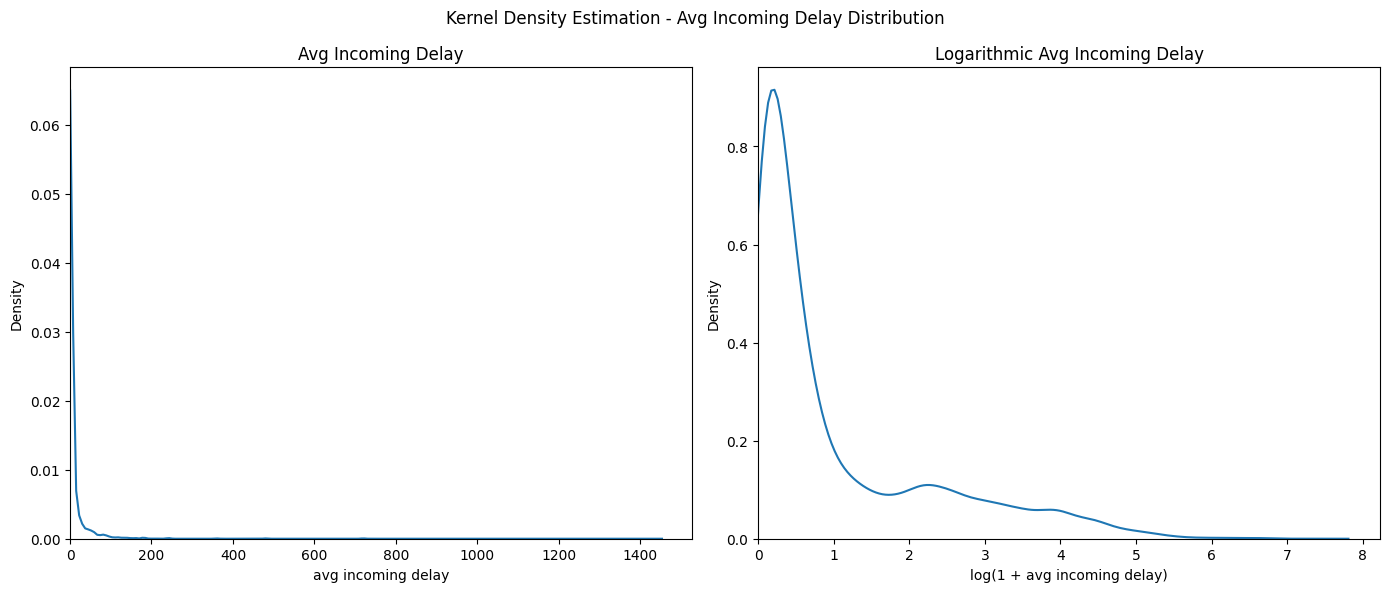

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Kernel Density estimation - avg incoming delay distribution".title())
# KDE plot
sns.kdeplot(df["avg_incoming_delay"].dropna(), ax=axes[0])
axes[0].set_title("Avg Incoming Delay".title())
axes[0].set_xlabel("avg incoming delay")
axes[0].set_xlim(left=0)

# Logarithmic KDE plot
sns.kdeplot(np.log1p((df["avg_incoming_delay"]).dropna()), ax=axes[1])
axes[1].set_title("Logarithmic Avg Incoming Delay".title())
axes[1].set_xlabel("log(1 + avg incoming delay)")
axes[1].set_xlim(left=0)

plt.tight_layout()
plt.savefig(dir_config.graph_dir / "figure_1_avg_incoming_delay_distribution.png")
plt.show()

In [11]:
df["avg_incoming_delay_is_zero"] = np.where(
    df["avg_incoming_delay"] == 0, "zero", "non-zero"
)
df["avg_incoming_delay_is_zero"].value_counts(normalize=True).round(2)

avg_incoming_delay_is_zero
non-zero    0.97
zero        0.03
Name: proportion, dtype: float64

The daily average of the incoming delays is heavily skewed to the left.

Taking the log(1+x) still yields a strongly left-skewed distribution. The right tail is stronger however

About 97 percent of observations are non-zero

### Descriptive statistics of the explanatory variable

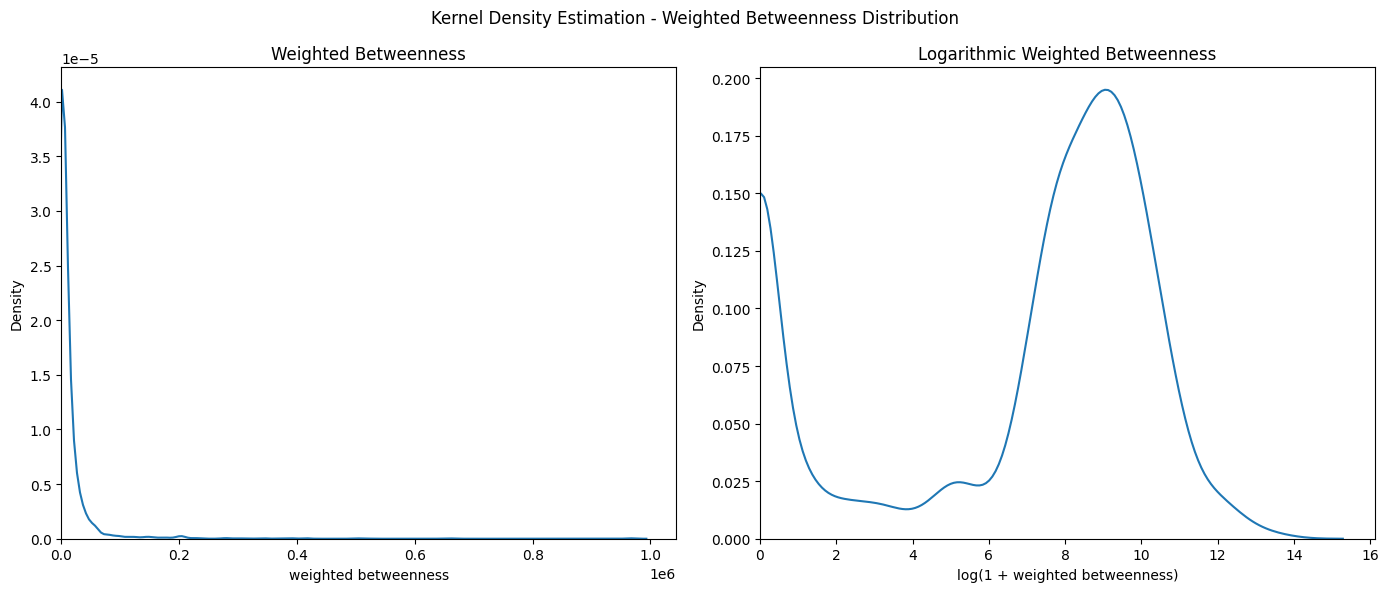

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Kernel Density estimation - weighted betweenness distribution".title())
# KDE plot
sns.kdeplot(df["weighted_betweenness"], ax=axes[0])
axes[0].set_title("Weighted betweenness".title())
axes[0].set_xlabel("weighted betweenness")
axes[0].set_xlim(left=0)

# Logarithmic KDE plot
sns.kdeplot(np.log1p(df["weighted_betweenness"]), ax=axes[1])
axes[1].set_title("Logarithmic weighted betweenness".title())
axes[1].set_xlabel("log(1 + weighted betweenness)")
axes[1].set_xlim(left=0)

plt.tight_layout()
plt.savefig(dir_config.graph_dir / "figure_2_weighted_betweenness_distribution.png")
plt.show()

In [13]:
df["weighted_betweenness_is_zero"] = np.where(
    df["weighted_betweenness"] == 0, "zero", "non-zero"
)
df["weighted_betweenness_is_zero"].value_counts(normalize=True).round(2)

weighted_betweenness_is_zero
non-zero    0.82
zero        0.18
Name: proportion, dtype: float64

The weighted betweenness seems to be a lot closer to log-normal.

Considering the `log(1+x)`, there is one mode at 0 and another around 9.

About 82 percent of observations are non-zero

In [14]:
# Looking at the cross-tabulation of the dependent and independent variables
pd.crosstab(df["weighted_betweenness_is_zero"], df["avg_incoming_delay_is_zero"])

avg_incoming_delay_is_zero,non-zero,zero
weighted_betweenness_is_zero,,
non-zero,22283,435
zero,4586,411


Cross-tabulating the two, we can see that the zeroes are usually not occuring at the same time.

### Descriptive statistics of the control variables


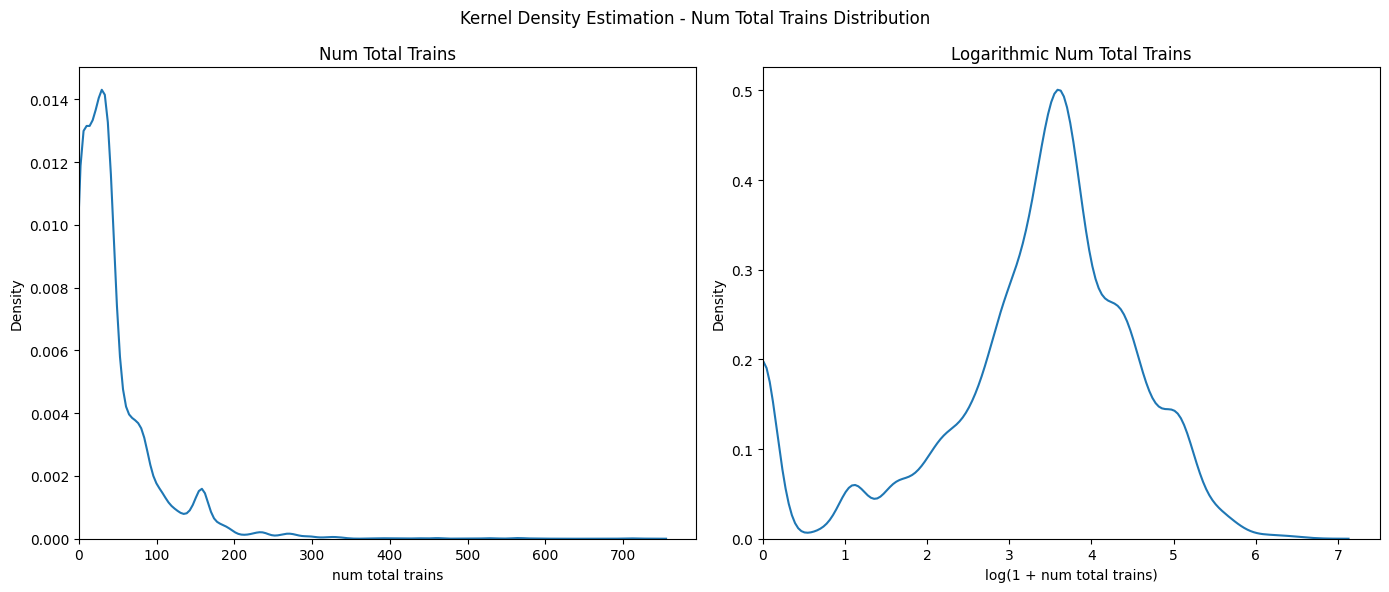

In [15]:
# distribution of num_total_trains
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Kernel Density estimation - num total trains distribution".title())
# KDE plot
sns.kdeplot(df["num_total_trains"].dropna(), ax=axes[0])
axes[0].set_title("Num Total Trains".title())
axes[0].set_xlabel("num total trains")
axes[0].set_xlim(left=0)

# Logarithmic KDE plot
sns.kdeplot(np.log1p(df["num_total_trains"]).dropna(), ax=axes[1])
axes[1].set_title("Logarithmic Num Total Trains".title())
axes[1].set_xlabel("log(1 + num total trains)")
axes[1].set_xlim(left=0)

plt.tight_layout()
plt.savefig(dir_config.graph_dir / "figure_3_num_total_trains_distribution.png")
plt.show()

In [16]:
# distribution of day of week
pd.DataFrame(df["day_of_week_name"].value_counts(normalize=True).round(2))

,proportion
day_of_week_name,
Thursday,0.17
Wednesday,0.17
Friday,0.13
Saturday,0.13
Monday,0.13
Sunday,0.13
Tuesday,0.13


In [17]:
# creating logaritmic variable for weightedbetweenness, avg_incoming_delay and num_total_trains
# log(1 + weighted_betweenness)
df["log_weighted_betweenness"] = np.log1p(df["weighted_betweenness"])
df["log_avg_incoming_delay"] = np.log1p(df["avg_incoming_delay"])
df["log_num_total_trains"] = np.log1p(df["num_total_trains"])

In [18]:
# parirwise correlation
df[
    ["log_avg_incoming_delay", "log_weighted_betweenness", "log_num_total_trains"]
].corr().to_excel(
    dir_config.table_dir / "table_4_pairwise_correlation.xlsx",
    float_format="%.2f",
    index=True,
)

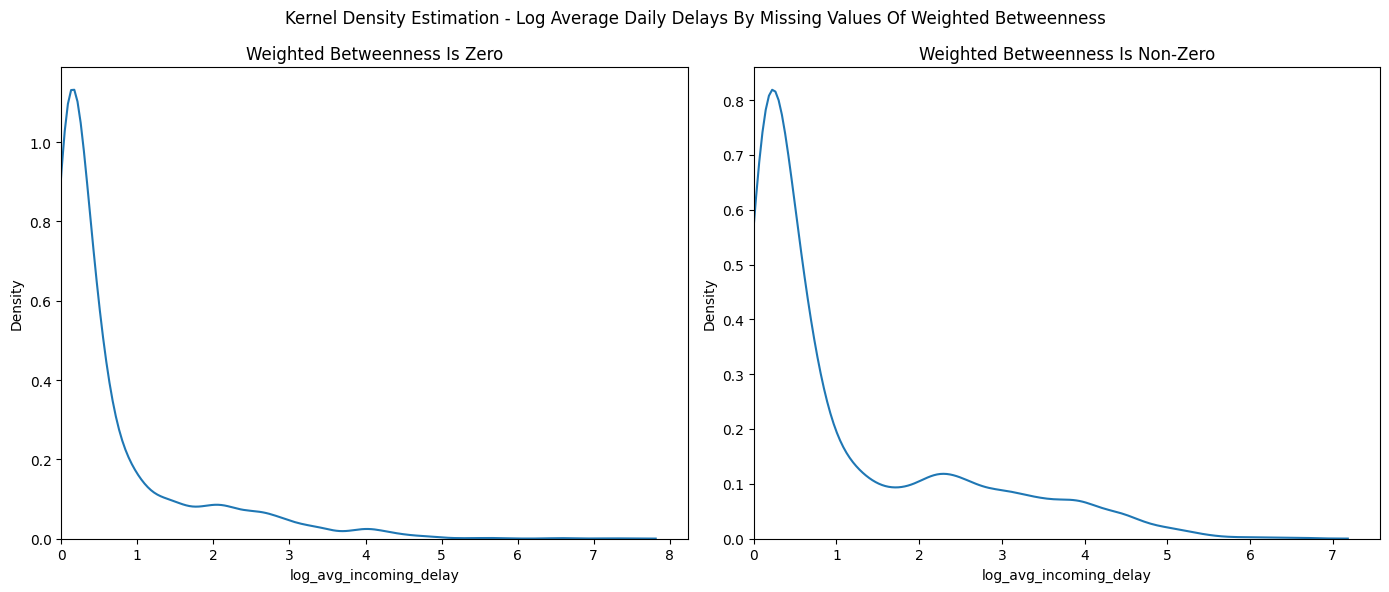

In [19]:
# Distribution of the log_avg_incoming_delay by missing values of the log_weighted_betweenness
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(
    "Kernel Density estimation - log average daily delays by missing values of weighted betweenness".title()
)
# KDE plot
sns.kdeplot(
    df[df["weighted_betweenness"] == 0]["log_avg_incoming_delay"].dropna(), ax=axes[0]
)
axes[0].set_title("Weighted Betweenness is Zero".title())
axes[0].set_xlabel("log_avg_incoming_delay")
axes[0].set_xlim(left=0)

# Logarithmic KDE plot
sns.kdeplot(
    df[df["weighted_betweenness"] != 0]["log_avg_incoming_delay"].dropna(), ax=axes[1]
)
axes[1].set_title("Weighted Betweenness is Non-Zero".title())
axes[1].set_xlabel("log_avg_incoming_delay")
axes[1].set_xlim(left=0)

plt.tight_layout()
# plt.savefig(
#     dir_config.graph_dir / "log_avg_incoming_delay_by_missing_weighted_betweenness.png"
# )
plt.show()

The distribution's right tail seems to be stronger when the main dependent variable is not zero.
This means there is greater variance, which is good for regression.

### Daily violinplots of the distributions of the three main variables - if taking their logs

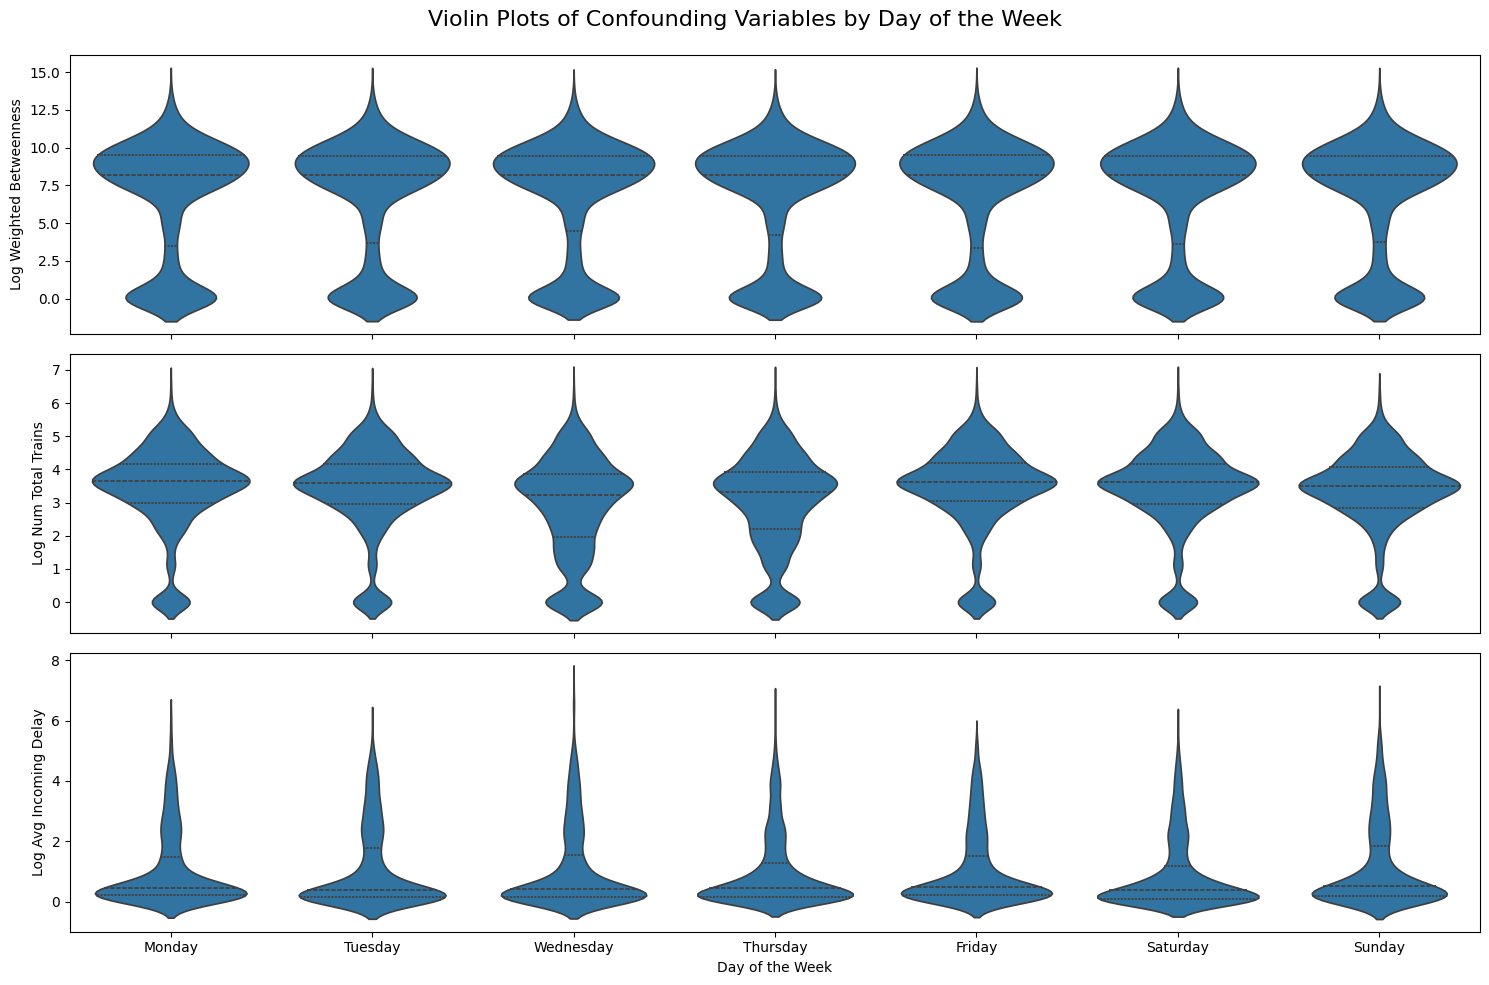

In [20]:
violin_plotter = ViolinPlotter(
    data=df,
    days_of_week_column="day_of_week_name",
    confounding_variables=[
        "log_weighted_betweenness",
        "log_num_total_trains",
        "log_avg_incoming_delay",
    ],
)

violin_plotter.plot(save_path=dir_config.graph_dir / "figure_4_violin_plots.png")


The distributions are fairly similar over the days, with the distribution of the total throughput of a stop being slitly more variable on Wendesday and Thursday

## Regressions and co-distributions

### Baseline models

In [21]:
# Minimal OLS regression
reg1 = smf.ols(
    "log_avg_incoming_delay ~ log_weighted_betweenness",
    data=df,
).fit(cov_type="HC1")

In [22]:
reg2 = smf.ols(
    "log_avg_incoming_delay ~ log_weighted_betweenness + log_num_total_trains",
    data=df,
).fit(cov_type="HC1")

In [23]:
# adding day of week as control variable
reg3 = smf.ols(
    "log_avg_incoming_delay ~ log_weighted_betweenness + log_num_total_trains + day_of_week_name",
    data=df,
).fit(cov_type="HC1")

In [24]:
# interacting date with the weighted betweenness
reg4 = smf.ols(
    "log_avg_incoming_delay ~ log_weighted_betweenness * day_of_week_name + log_num_total_trains",
    data=df,
).fit(cov_type="HC1")

In [25]:
# interacting weekend with the weighted betweenness
reg5 = smf.ols(
    "log_avg_incoming_delay ~ log_weighted_betweenness * is_weekend + log_num_total_trains",
    data=df,
).fit(cov_type="HC1")

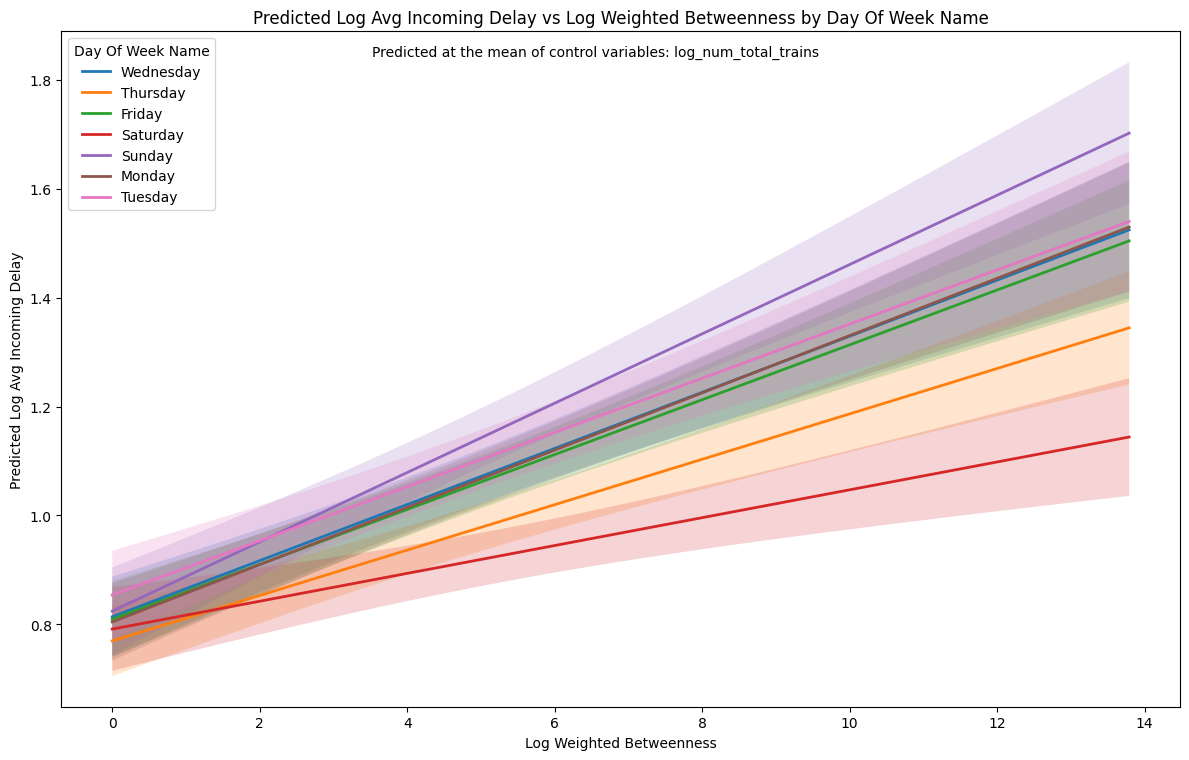

Plot saved to C:\Users\ijara_go12\CEUProjects\mav_requests_analysis\mav-analysis\results\graphs\figure_5_day_of_week_interaction.png


In [26]:
# Example usage
day_of_week_plotter = InteractionCIPlotter(
    regression_model=reg4,
    dataframe=df,
    output_path=dir_config.graph_dir / "figure_5_day_of_week_interaction.png",
    interaction_term="day_of_week_name",
    explanatory_variable="log_weighted_betweenness",
    dependent_variable="log_avg_incoming_delay",
    control_variables=["log_num_total_trains"],
)
day_of_week_plotter.create_plot()


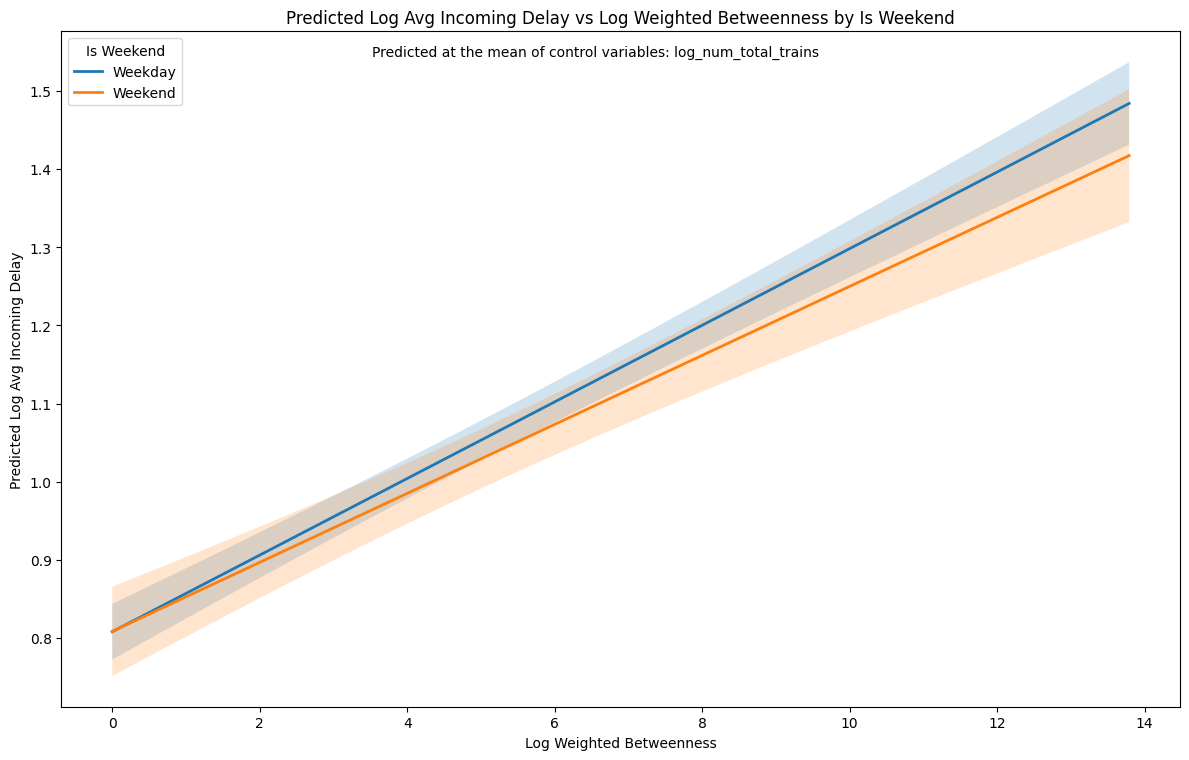

Plot saved to C:\Users\ijara_go12\CEUProjects\mav_requests_analysis\mav-analysis\results\graphs\figure_6_weekend_interaction_plot.png


In [27]:
weekend_plotter = InteractionCIPlotter(
    regression_model=reg5,
    dataframe=df,
    output_path=dir_config.graph_dir / "figure_6_weekend_interaction_plot.png",
    interaction_term="is_weekend",
    explanatory_variable="log_weighted_betweenness",
    dependent_variable="log_avg_incoming_delay",
    control_variables=["log_num_total_trains"],
)
weekend_plotter.create_plot()

In [28]:
# stargazer table
stargazer = Stargazer([reg1, reg2, reg3, reg4, reg5])
stargazer.title("Table 3: The baseline OLS regression models")
stargazer.custom_columns(
    [
        "Bivariate OLS",
        "Total Throughput Control",
        "Day of Week Dummies",
        "Day of Week Interactions",
        "Weekend Interactions",
    ],
    [1, 1, 1, 1, 1],
)
stargazer.show_degrees_of_freedom(False)

# order the covariates
stargazer.covariate_order(
    [
        "Intercept",
        "log_weighted_betweenness",
        "log_num_total_trains",
        "is_weekend[T.Weekend]",
        "log_weighted_betweenness:is_weekend[T.Weekend]",
        # "day_of_week_name[T.Monday]",
        # "day_of_week_name[T.Tuesday]",
        # "day_of_week_name[T.Wednesday]",
        # "day_of_week_name[T.Thursday]",
        # # "day_of_week_name[T.Friday]",
        # "day_of_week_name[T.Saturday]",
        # "day_of_week_name[T.Sunday]",
        # "log_weighted_betweenness:day_of_week_name[T.Monday]",
        # "log_weighted_betweenness:day_of_week_name[T.Tuesday]",
        # "log_weighted_betweenness:day_of_week_name[T.Wednesday]",
        # "log_weighted_betweenness:day_of_week_name[T.Thursday]",
        # # "log_weighted_betweenness:day_of_week_name[T.Friday]",
        # "log_weighted_betweenness:day_of_week_name[T.Saturday]",
        # "log_weighted_betweenness:day_of_week_name[T.Sunday]",
    ]
)

# rename day of week names
stargazer.rename_covariates(
    {
        "Intercept": "Intercept",
        "log_weighted_betweenness": "Log Weighted Betweenness",
        "log_num_total_trains": "Log Num Total Trains",
        "day_of_week_name[T.Monday]": "Monday",
        "day_of_week_name[T.Tuesday]": "Tuesday",
        "day_of_week_name[T.Wednesday]": "Wednesday",
        "day_of_week_name[T.Thursday]": "Thursday",
        "day_of_week_name[T.Friday]": "Friday",
        "day_of_week_name[T.Saturday]": "Saturday",
        "day_of_week_name[T.Sunday]": "Sunday",
        "is_weekend[T.Weekend]": "Weekend",
        "log_weighted_betweenness:day_of_week_name[T.Monday]": "Log Weighted Betweenness x Monday",
        "log_weighted_betweenness:day_of_week_name[T.Tuesday]": "Log Weighted Betweenness x Tuesday",
        "log_weighted_betweenness:day_of_week_name[T.Wednesday]": "Log Weighted Betweenness x Wednesday",
        "log_weighted_betweenness:day_of_week_name[T.Thursday]": "Log Weighted Betweenness x Thursday",
        "log_weighted_betweenness:day_of_week_name[T.Friday]": "Log Weighted Betweenness x Friday",
        "log_weighted_betweenness:day_of_week_name[T.Saturday]": "Log Weighted Betweenness x Saturday",
        "log_weighted_betweenness:day_of_week_name[T.Sunday]": "Log Weighted Betweenness x Sunday",
        "log_weighted_betweenness:is_weekend[T.Weekend]": "Log Weighted Betweenness x Weekend",
    }
)


# add notes for weekday dummies and interactions
stargazer.add_line("Weekday Dummies", ["NO", "NO", "YES", "YES", "NO"])
stargazer.add_line("Weekday Interactions", ["NO", "NO", "NO", "YES", "NO"])

# save the table to a file
with open(dir_config.table_dir / "table_3_baseline_regression_table.html", "w") as f:
    f.write(stargazer.render_html())

stargazer

### Different functional forms?

In [29]:
# TODO:
# Analyze different functional forms of the explanatory variable

c:\Users\ijara_go12\AppData\Local\pypoetry\Cache\virtualenvs\mav-analysis-mQkDodj7-py3.11\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


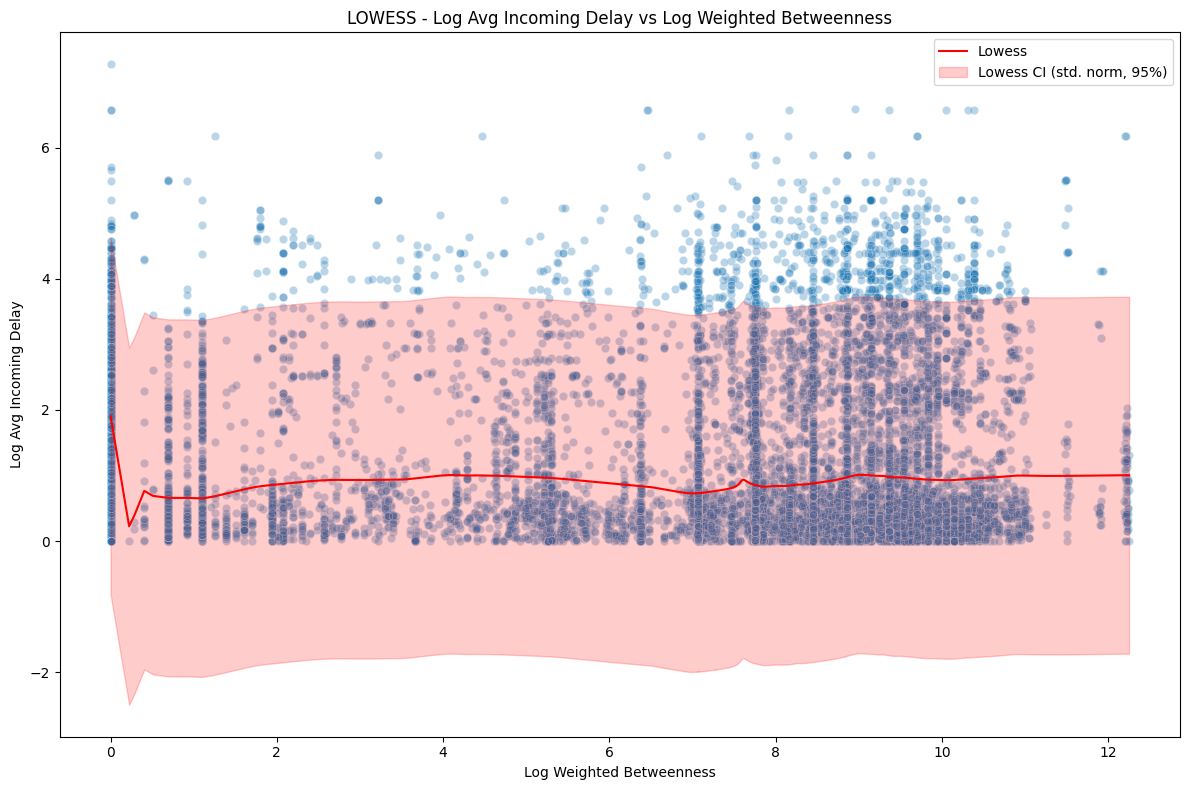

In [30]:
# Example usage
delay_to_btwnnss_plotter = ScatterLowessCIPlotter(
    title="LOWESS - Log Avg Incoming Delay vs Log Weighted Betweenness",
    xlabel="Log Weighted Betweenness",
    ylabel="Log Avg Incoming Delay",
    x_var="log_weighted_betweenness",
    y_var="log_avg_incoming_delay",
    data=df,
)
delay_to_btwnnss_plotter.plot(
    save_path=dir_config.graph_dir
    / "figure_7_lowess_log_avg_incoming_delay_vs_weighted_betweenness.png"
)

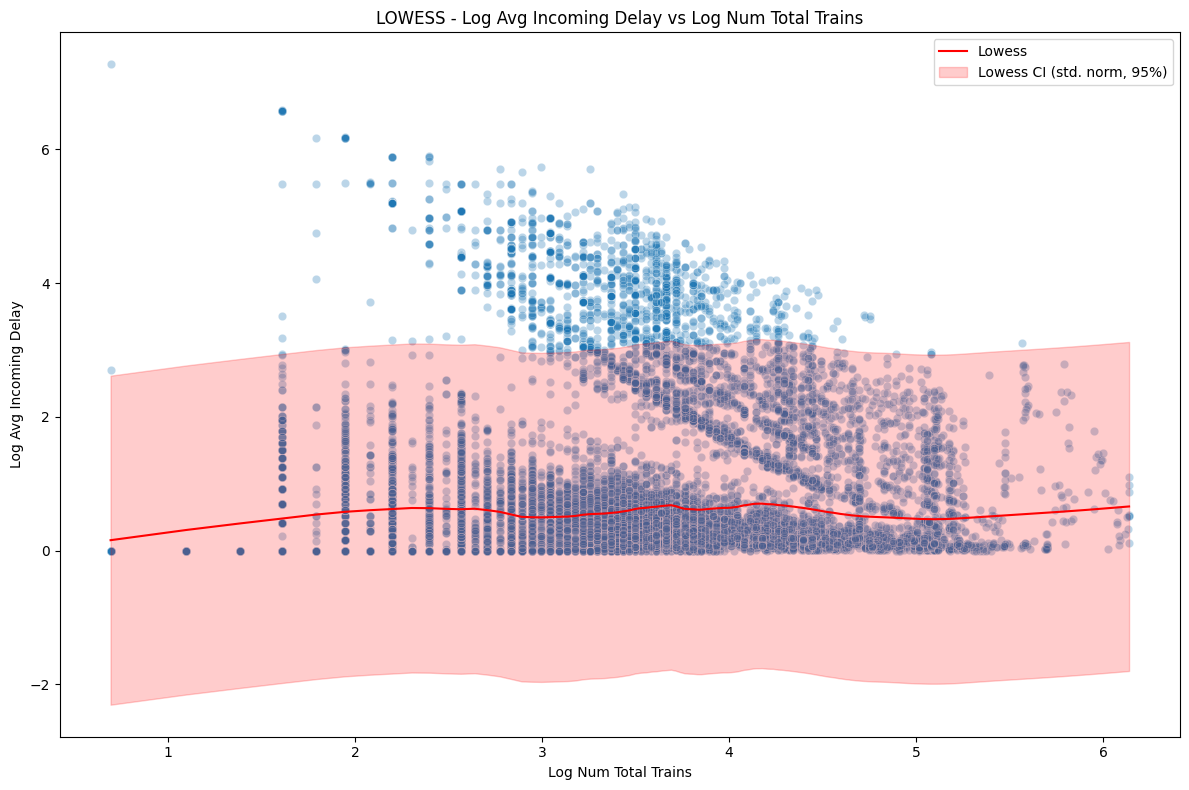

In [31]:
delay_to_thrhgpt_plotter = ScatterLowessCIPlotter(
    title="LOWESS - Log Avg Incoming Delay vs Log Num Total Trains",
    xlabel="Log Num Total Trains",
    ylabel="Log Avg Incoming Delay",
    x_var="log_num_total_trains",
    y_var="log_avg_incoming_delay",
    data=df,
)
delay_to_thrhgpt_plotter.plot(
    save_path=dir_config.graph_dir
    / "figure_8_lowess_log_avg_incoming_delay_vs_num_total_trains.png"
)

Based on the lowess estimations, we cannot see a dominant non-linear functional form. We will not introduce quadratic terms of other interactions.


### Extended models

In [32]:
# Christmas and New Year's Eve dummy variables from 22nd December to 2nd January
df["christmas_period"] = pd.Categorical(
    np.where(
        (df["date"] >= "2024-12-22") & (df["date"] <= "2025-01-02"),
        "Christmas",
        "Not Christmas",
    ),
    categories=["Christmas", "Not Christmas"],
    ordered=True,
)

In [33]:
df["christmas_period"].value_counts(normalize=True).to_excel(
    dir_config.table_dir / "table_2_christmas_period_distribution.xlsx"
)

In [34]:
# Add more control variables
#   total distance, total times, total speed, average delay of neighbors, christmas period dummy
#   interaction between christmas period and log_weighted_betweenness and plot the predicted values against each other.

reg6 = smf.ols(
    "log_avg_incoming_delay ~ log_weighted_betweenness*C(day_of_week_name, Treatment(reference='Monday')) + log_num_total_trains + total_distance_strength + total_time_strength + total_speed_strength",
    data=df,
).fit(cov_type="HC1")

reg7 = smf.ols(
    "log_avg_incoming_delay ~ log_weighted_betweenness*C(day_of_week_name, Treatment(reference='Monday')) + log_num_total_trains + total_distance_strength + total_time_strength + total_speed_strength + avg_neighboring_delay",
    data=df,
).fit(cov_type="HC1")

reg8 = smf.ols(
    "log_avg_incoming_delay ~ log_weighted_betweenness*C(christmas_period, Treatment(reference='Not Christmas')) + log_num_total_trains + total_distance_strength + total_time_strength + total_speed_strength + avg_neighboring_delay",
    data=df,
).fit(cov_type="HC1")

In [35]:
# stargazer table
stargazer = Stargazer([reg6, reg7, reg8])
stargazer.title("Table 5: The OLS regression models with additional control variables")

stargazer.custom_columns(
    [
        "Total Throughput Control",
        "Average Neighboring Delay",
        "Christmas Period",
    ],
    [1, 1, 1],
)

stargazer.show_degrees_of_freedom(False)

# renumber the models to be 6, 7, 8
stargazer.show_model_numbers(False)
stargazer.column_labels = ["(6)", "(7)", "(8)"]

# order the covariates
stargazer.covariate_order(
    [
        "Intercept",
        "log_weighted_betweenness",
        "log_num_total_trains",
        # "C(day_of_week_name, Treatment(reference='Monday')[T.Monday]",
        # "C(day_of_week_name, Treatment(reference='Monday')[T.Tuesday]",
        # "C(day_of_week_name, Treatment(reference='Monday')[T.Wednesday]",
        # "C(day_of_week_name, Treatment(reference='Monday')[T.Thursday]",
        # "C(day_of_week_name, Treatment(reference='Monday')[T.Friday]",
        # "C(day_of_week_name, Treatment(reference='Monday')[T.Saturday]",
        # "C(day_of_week_name, Treatment(reference='Monday')[T.Sunday]",
        # "log_weighted_betweenness:C(day_of_week_name, Treatment(reference='Monday')[T.Monday]",
        # "log_weighted_betweenness:C(day_of_week_name, Treatment(reference='Monday')[T.Tuesday]",
        # "log_weighted_betweenness:C(day_of_week_name, Treatment(reference='Monday')[T.Wednesday]",
        # "log_weighted_betweenness:C(day_of_week_name, Treatment(reference='Monday')[T.Thursday]",
        # "log_weighted_betweenness:C(day_of_week_name, Treatment(reference='Monday')[T.Friday]",
        # "log_weighted_betweenness:C(day_of_week_name, Treatment(reference='Monday')[T.Saturday]",
        # "log_weighted_betweenness:C(day_of_week_name, Treatment(reference='Monday')[T.Sunday]",
        "total_distance_strength",
        "total_time_strength",
        "total_speed_strength",
        "avg_neighboring_delay",
        "C(christmas_period, Treatment(reference='Not Christmas'))[T.Christmas]",
        "log_weighted_betweenness:C(christmas_period, Treatment(reference='Not Christmas'))[T.Christmas]",
    ]
)

# rename non-filtered covariates (days of week are filtered)
stargazer.rename_covariates(
    {
        "Intercept": "Intercept",
        "log_weighted_betweenness": "Log Weighted Betweenness",
        "log_num_total_trains": "Log Num Total Trains",
        "total_distance_strength": "Total Distance Strength",
        "total_time_strength": "Total Time Strength",
        "total_speed_strength": "Total Speed Strength",
        "avg_neighboring_delay": "Avg Neighboring Delay",
        "C(christmas_period, Treatment(reference='Not Christmas'))[T.Christmas]": "Christmas Period",
        "log_weighted_betweenness:C(christmas_period, Treatment(reference='Not Christmas'))[T.Christmas]": "Log Weighted Betweenness x Christmas Period",
    }
)


# add notes for weekday dummies and interactions
stargazer.add_line("Weekday Dummies", ["YES", "YES", "NO"])
stargazer.add_line("Weekday Interactions", ["YES", "YES", "NO"])

# save the table to a file
with open(
    dir_config.table_dir / "table_5_regression_table_additional_controls.html", "w"
) as f:
    f.write(stargazer.render_html())

stargazer

### Robustness checks for extended models

In [36]:
# Linear model (linear avg_incoming_delays, weighted_betweenness_centrality, etc. for comparison with the same set of control variables)

reg9 = smf.ols(
    "avg_incoming_delay ~ weighted_betweenness*C(day_of_week_name, Treatment(reference='Monday')) + num_total_trains + total_distance_strength + total_time_strength + total_speed_strength",
    data=df,
).fit(cov_type="HC1")

reg10 = smf.ols(
    "avg_incoming_delay ~ weighted_betweenness*C(day_of_week_name, Treatment(reference='Monday')) + num_total_trains + total_distance_strength + total_time_strength + total_speed_strength + avg_neighboring_delay",
    data=df,
).fit(cov_type="HC1")

reg11 = smf.ols(
    "avg_incoming_delay ~ weighted_betweenness*C(christmas_period, Treatment(reference='Not Christmas')) + num_total_trains + total_distance_strength + total_time_strength + total_speed_strength + avg_neighboring_delay",
    data=df,
).fit(cov_type="HC1")

# stargazer table
stargazer = Stargazer([reg9, reg10, reg11])

stargazer.title("Table 6: Robustness check with linear model")

stargazer.custom_columns(
    [
        "Total Throughput Control",
        "Average Neighboring Delay",
        "Christmas Period",
    ],
    [1, 1, 1],
)

stargazer.show_degrees_of_freedom(False)

# renumber the models to be 9, 10, 11
stargazer.show_model_numbers(False)
stargazer.column_labels = ["(9)", "(10)", "(11)"]

# order the covariates

stargazer.covariate_order(
    [
        "Intercept",
        "weighted_betweenness",
        "num_total_trains",
        "total_distance_strength",
        "total_time_strength",
        "total_speed_strength",
        "avg_neighboring_delay",
        # "day_of_week_name[T.Monday]",
        # "day_of_week_name[T.Tuesday]",
        # "day_of_week_name[T.Wednesday]",
        # "day_of_week_name[T.Thursday]",
        # "day_of_week_name[T.Friday]",
        # "day_of_week_name[T.Saturday]",
        # "day_of_week_name[T.Sunday]",
        # "weighted_betweenness:day_of_week_name[T.Monday]",
        # "weighted_betweenness:day_of_week_name[T.Tuesday]",
        # "weighted_betweenness:day_of_week_name[T.Wednesday]",
        # "weighted_betweenness:day_of_week_name[T.Thursday]",
        # "weighted_betweenness:day_of_week_name[T.Friday]",
        # "weighted_betweenness:day_of_week_name[T.Saturday]",
        # "weighted_betweenness:day_of_week_name[T.Sunday]",
        "C(christmas_period, Treatment(reference='Not Christmas'))[T.Christmas]",
        "weighted_betweenness:C(christmas_period, Treatment(reference='Not Christmas'))[T.Christmas]",
    ]
)

# rename non-filtered covariates (days of week are filtered)
stargazer.rename_covariates(
    {
        "Intercept": "Intercept",
        "weighted_betweenness": "Weighted Betweenness",
        "num_total_trains": "Num Total Trains",
        "total_distance_strength": "Total Distance Strength",
        "total_time_strength": "Total Time Strength",
        "total_speed_strength": "Total Speed Strength",
        "avg_neighboring_delay": "Avg Neighboring Delay",
        "C(christmas_period, Treatment(reference='Not Christmas'))[T.Christmas]": "Christmas Period",
        "weighted_betweenness:C(christmas_period, Treatment(reference='Not Christmas'))[T.Christmas]": "Weighted Betweenness x Christmas Period",
    }
)

# add notes for weekday dummies and interactions
stargazer.add_line("Weekday Dummies", ["YES", "YES", "NO"])
stargazer.add_line("Weekday Interactions", ["YES", "YES", "NO"])

# save the table to a file
with open(
    dir_config.table_dir / "table_6_regression_table_linear_comparison.html", "w"
) as f:
    f.write(stargazer.render_html())

stargazer
